## Final Project Submission

Please fill out:
* Student name: Aleigha (Aly) Sardina-Spevack
* Student pace: self paced
* Scheduled project review date/time: TBD
* Instructor name: Eli Thomas
* Blog post URL: TBD


# New York Stock Exchange

Long have analysts, traders, and investors tried to predict future stock prices.  Even if you come up with a plan or model that works for a while, it is generally great until for some reason it doesn't work.  Whether there was a break down in underlying correlations or new news of scandal caused stock price to plummet.  If you could crack the whole code you'd be a bilionaire in about the same amout of time as it takes to click on your favorite Netflix program.  

If any type of model is going to be able to finally do it, I would be willing to bet that model would fall into the deep learning category.  So that is exactly what we are going to try to do.

## The Data

The data set we will be working with is from the New York Stock Exhange (NYSE) and represent the historical prices and other fundamental data points of the S&P 500 from 2010 to the end 2016.


Dataset consists of following files:

prices.csv: raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time, this set doesn't account for that.
prices-split-adjusted.csv: same as prices, but there have been added adjustments for splits.
securities.csv: general description of each company with division on sectors
fundamentals.csv: metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.

The majority of our focus will be on the prices-split-adjusted.csv file, as this contains the adjusted prices for the stocks we will be trying to predict.

## The Process

In General, we will follow the Data Science process, Cleaning, Exploring, and Analyzing iteratively until we arive at a useable model.  

As always we can begin by importing all the necessary libraries for our notebook.

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import keras
from keras.layers import LSTM, GRU, Dense, GlobalMaxPool1D, Embedding, Dropout
from keras.models import Sequential
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.filterwarnings("ignore")
sns.set_style(style='whitegrid')
sns.set_palette('Set1')

Using TensorFlow backend.


In [2]:
# import all stock prices 
df = pd.read_csv("nyse/prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


There are some really great metrics and facinating exploration we can do with what we have in this dataframe.  We'll start with some basic summary statitics and move forward to more exploration.

Lets see how many stocks there are in our dataset.

In [3]:
print("There are {} stocks.".format(len(set(df.symbol))))

There are 501 stocks.


In [4]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


This is a really fun to see the whole population of the S&P 500.  The smalled stock in the S&P 500 had a low of 1.50 per share and the most expensive stock for this time frame was 1,600.93 per share.  Other than volume, we can see how the other metics might be a little skewed given the standard deviation is actually greater than the mean price.  With one stock strading at 1.50 and another over 1,600, that's not really comparing apples to apples!  

We can look at some price and volume movements for a single stock next.  Let's have a look at Citigroup, the Bank Holding Company that owns Citibank, N.A.

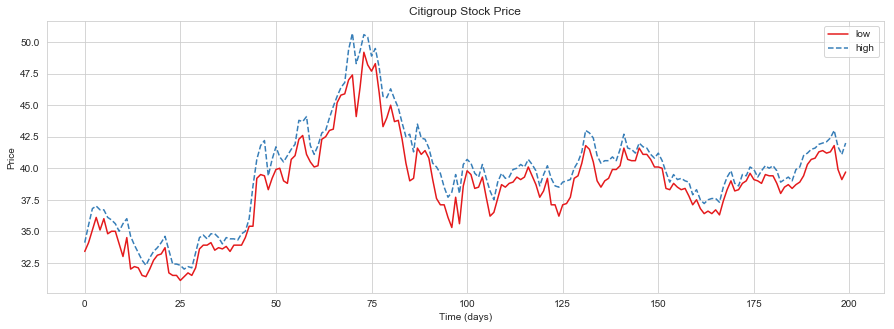

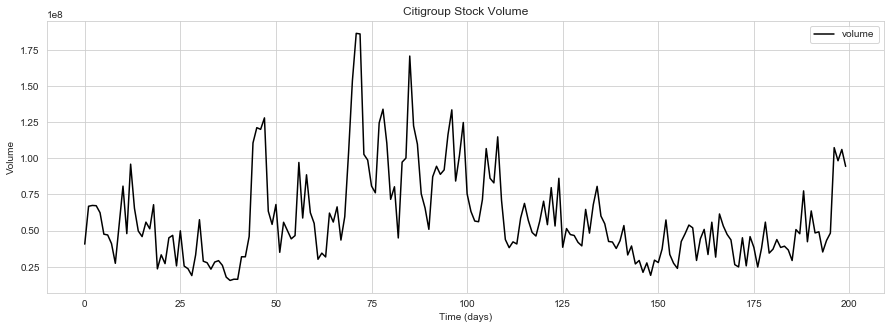

In [5]:
plt.figure(figsize=(15, 5));
#Truncacted to the first 200 days for clearer visual
plt.plot(df[df.symbol == 'C'].low.values[:200],linestyle = '-', label='low')
plt.plot(df[df.symbol == 'C'].high.values[:200],linestyle = '--', label='high')
plt.title('Citigroup Stock Price')
plt.xlabel('Time (days)')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15, 5));
plt.plot(df[df.symbol == 'C'].volume.values[:200], color='black', label='volume')
plt.title('Citigroup Stock Volume')
plt.xlabel('Time (days)')
plt.ylabel('Volume')
plt.legend(loc='best')
plt.show()

Interesting, it looks like Citigroup's volume of trades per day decreased stadily as the company rebounded from its lower points in this period. 


This didn't happen in a vaccum, so we can take a slice of the data and look at a number of metrics to get a feel for what the economy looked like and try to see if there were any idiosyncratic hiccups in any one particular stock that belied news particular to the company or industry.

A caution: While the NYSE can be thought of as a proxy for the very general health of the economy and the S&P 500 can be thought of as a general proxy for the NYSE, we should be cognizant of generalizations and their impact on our analysis.  Our analysis shouldn't really be affected in this regard, but it is worth noting for anyone thinking about the bigger picture. 


Let's review the first 50 stocks and see what their high points looked like in this period

In [6]:
def get_max_high(sym):
    highs = df[df['symbol'] == sym].high.values
    return(max(highs))

In [7]:
highs = []
stocks = list(set(df.symbol))
for sym in stocks:
    highs.append(get_max_high(sym))

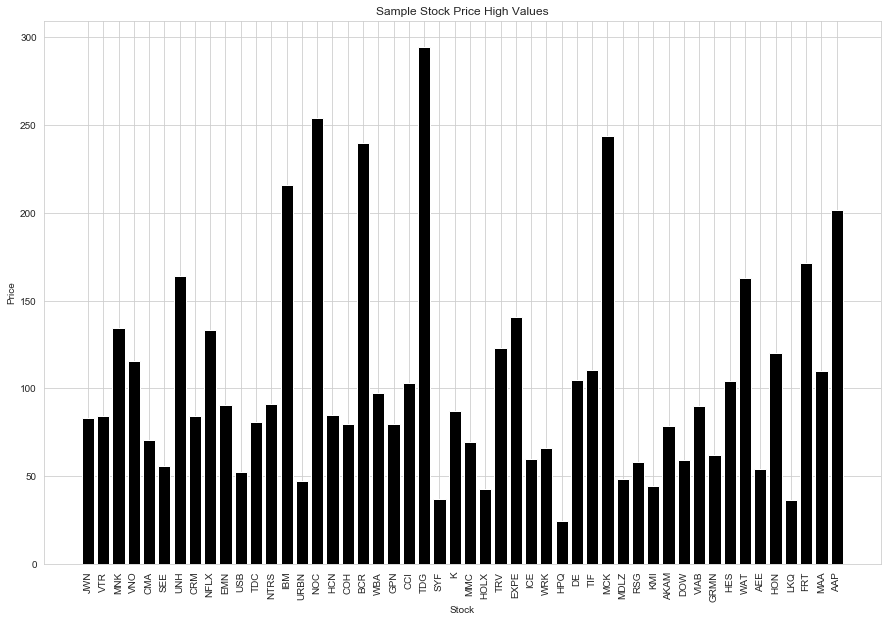

In [8]:
plt.figure(figsize=(15, 10))
plt.bar(stocks[:50],highs[:50], color='black')
plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Price High Values')
plt.ylabel('Price')
plt.xlabel('Stock')
plt.show()

Of course, we can do the same for lows.

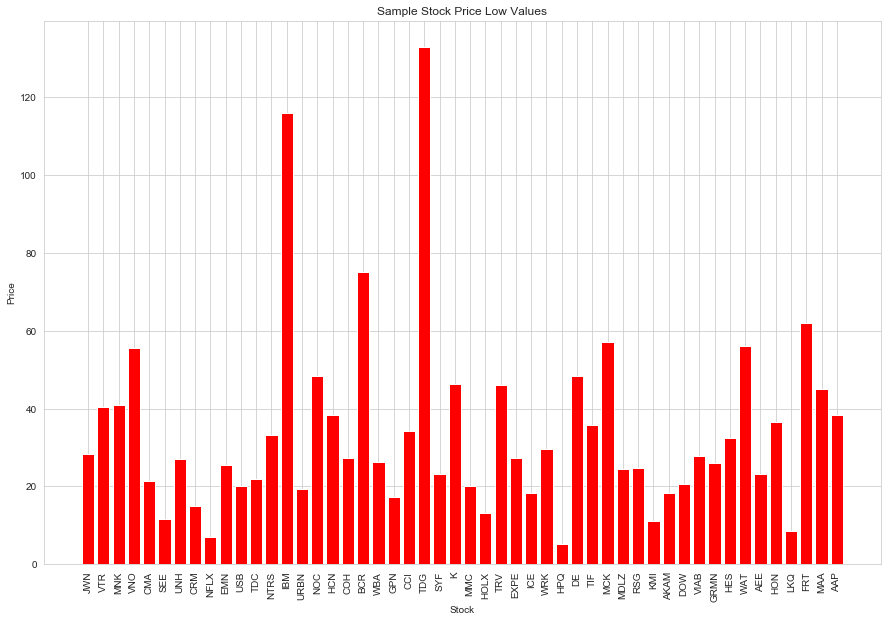

In [9]:
def get_min_low(sym):
    lows = df[df['symbol'] == sym].low.values
    return(min(lows))
lows = []
for sym in stocks:
    lows.append(get_min_low(sym))
    
plt.figure(figsize=(15, 10))
plt.bar(stocks[:50],lows[:50], color='red')
plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Price Low Values')
plt.ylabel('Price')
plt.xlabel('Stock')
plt.show()

We can layer these two visualizations together to see the absolute variability of the stocks.

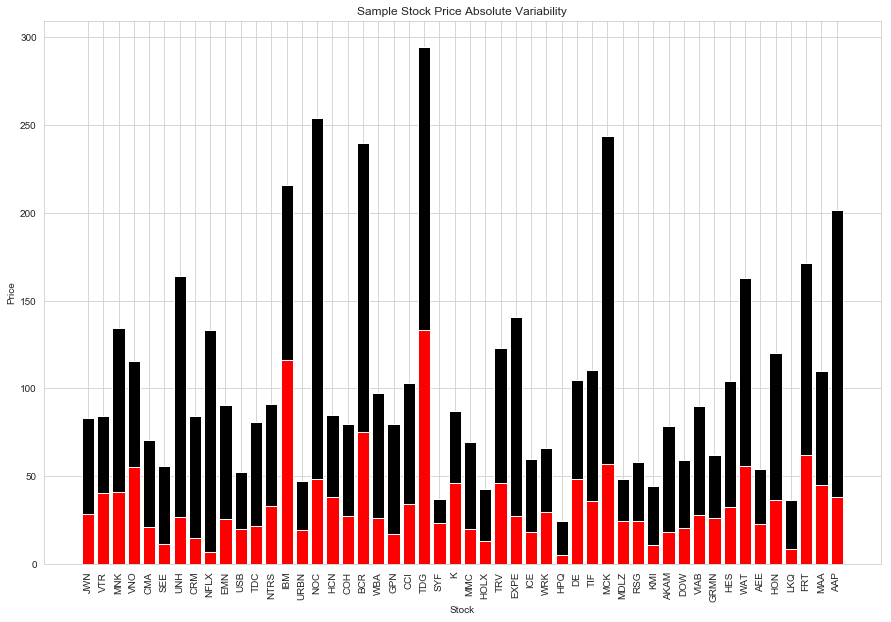

In [10]:
plt.figure(figsize=(15, 10))
plt.bar(stocks[:50],highs[:50], color='black')
plt.bar(stocks[:50],lows[:50], color='red')
plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Price Absolute Variability')
plt.ylabel('Price')
plt.xlabel('Stock')
plt.show()

Look at Chipotle ('CMG')! The stock went from under 100 to nearly 800 per share.  Let's see exactly what the highs and lows were.

In [11]:
high_cmg = []
low_cmg = []


low_cmg.append(get_min_low('CMG'))
high_cmg.append(get_max_high('CMG'))

print("Chipotle's maximum price is {}.".format(round(high_cmg[0],1)))
print("Chipotle's minimum price is {}.".format(round(low_cmg[0],1)))

Chipotle's maximum price is 758.6.
Chipotle's minimum price is 86.0.


This type of analysis would be really useful for risk management.  It gives an idea of recent volatility and may begin to allow the investment analyst to form opinion on whether the stock is a Buy, Hold, or Sell.  Some trading positions and investment portfolios require volitility minimums and maximums and seeing such wide swings may indicate that the shorter term models, while typical, may not be capturing all the risk.   

Let's look at January 2015 now for further exploration.  We can plot the total trade volume by stock on each Friday in January.  

In [12]:
jan2= df.loc['2015-01-02']
jan2_vol = jan2.volume.values

jan9= df.loc['2015-01-09']
jan9_vol = jan9.volume.values

jan16= df.loc['2015-01-16']
jan16_vol = jan16.volume.values

jan23= df.loc['2015-01-23']
jan23_vol = jan23.volume.values

jan30= df.loc['2015-01-30']
jan30_vol = jan30.volume.values



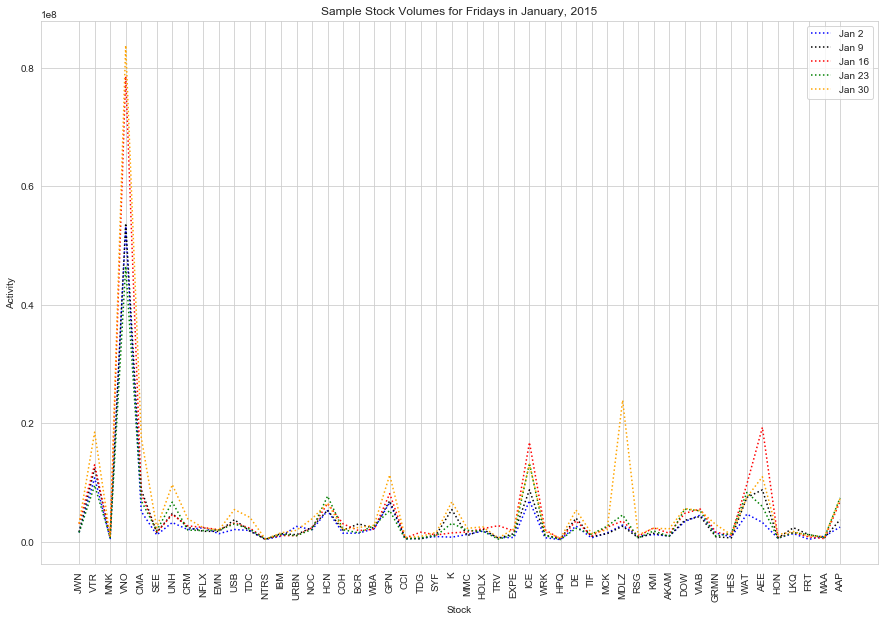

In [13]:
plt.figure(figsize=(15,10))
plt.plot(stocks[:50], jan2_vol[:50],color='blue',linestyle = ':',label='Jan 2')
plt.plot(stocks[:50], jan9_vol[:50],color='black',linestyle = ':',label='Jan 9')
plt.plot(stocks[:50], jan16_vol[:50],color='red',linestyle = ':',label='Jan 16')
plt.plot(stocks[:50], jan23_vol[:50],color='green',linestyle = ':',label='Jan 23')
plt.plot(stocks[:50], jan30_vol[:50],color='orange',linestyle = ':',label='Jan 30')

plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Volumes for Fridays in January, 2015' )
plt.ylabel('Activity')
plt.xlabel('Stock')
plt.legend(loc='best')
plt.show()

There are a few things that I would like to point out as interesting here.  First let's look at EES, or the WisdomTree U.S. SmallCap Fund.  It's an ETF that seeks to track the investment results of earnings-generating small-cap companies in the U.S. equity market.  There was a surge of activity with EES on January 30th compared to other Friday's in January. The second pattern that I want to point out is the last Friday (and business day) of the month has the most volume.  This is actually much clearer if we convert this to a bar graph.

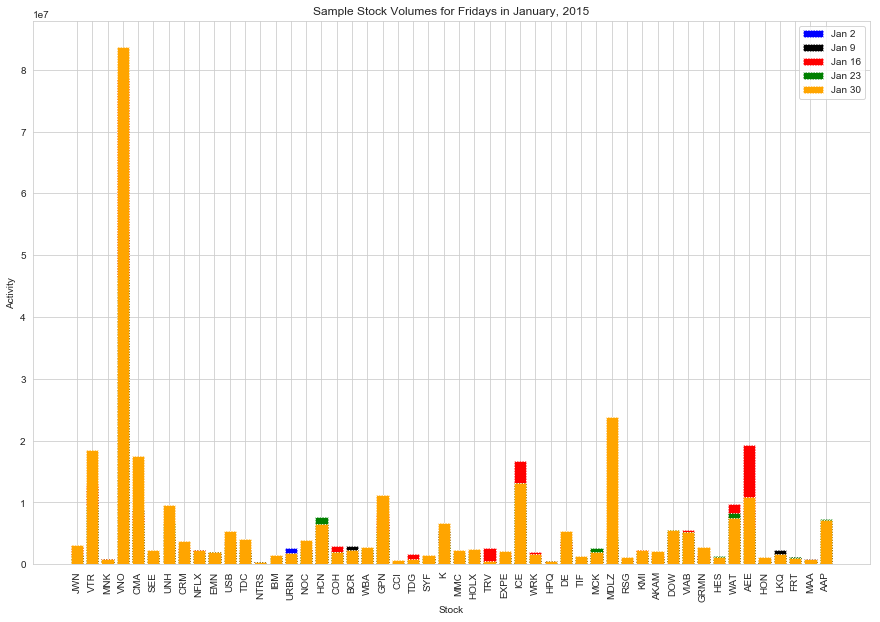

In [14]:
plt.figure(figsize=(15,10))
plt.bar(stocks[:50], jan2_vol[:50],color='blue',linestyle = ':',label='Jan 2')
plt.bar(stocks[:50], jan9_vol[:50],color='black',linestyle = ':',label='Jan 9')
plt.bar(stocks[:50], jan16_vol[:50],color='red',linestyle = ':',label='Jan 16')
plt.bar(stocks[:50], jan23_vol[:50],color='green',linestyle = ':',label='Jan 23')
plt.bar(stocks[:50], jan30_vol[:50],color='orange',linestyle = ':',label='Jan 30')

plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Volumes for Fridays in January, 2015' )
plt.ylabel('Activity')
plt.xlabel('Stock')
plt.legend(loc='best')
plt.show()

The January effect of stocks (where prices tend to rebound in January after lower prices in December) is likely driving more volume.  Appreciating capital likes company!  

So we can now turn our attention to the stock we are going to try to predict which is Google ('GOOG').  We'll start by visualing the opening vs the closing prices for the same time frame

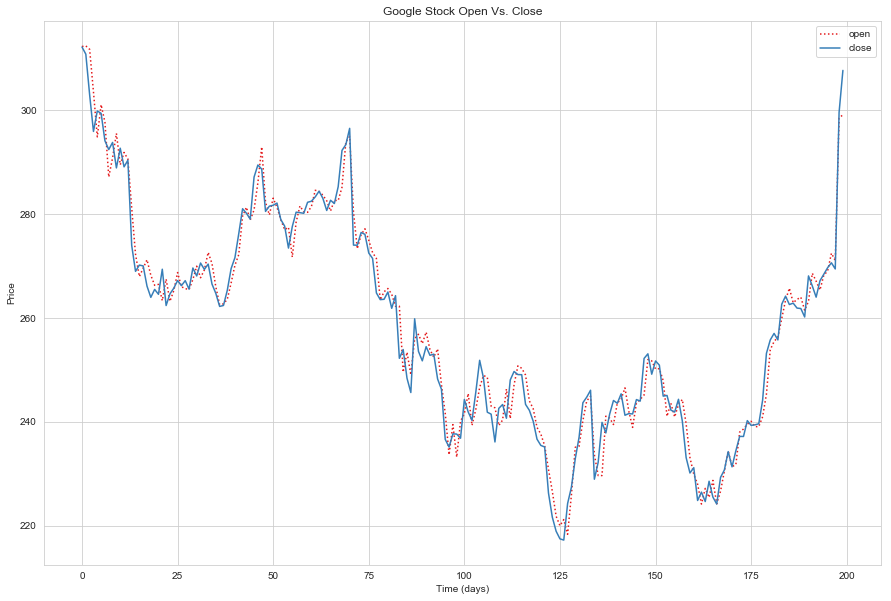

In [15]:
plt.figure(figsize=(15, 10));
#Truncacted to the first 200 days for clearer visual
plt.plot(df[df.symbol == 'GOOG'].open.values[:200],linestyle = ':', label='open')
plt.plot(df[df.symbol == 'GOOG'].close.values[:200],linestyle = '-', label='close')
plt.title('Google Stock Open Vs. Close')
plt.xlabel('Time (days)')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

Usually opening and closing valus don't differ very much, but you can see a few days where the opening value or the closing value is fairly significantly different from the other.  Often it's a day where there was big news regarding the company that either beat for fell short of expectations.  This news can be anything from announcing a long rumored product to hit the shelves to financial reporting to something industry wide, like tariffs on a particular part for a product.  Let's look at some of the other big tech giants (Apple and Microsoft) and see what the three look like together.



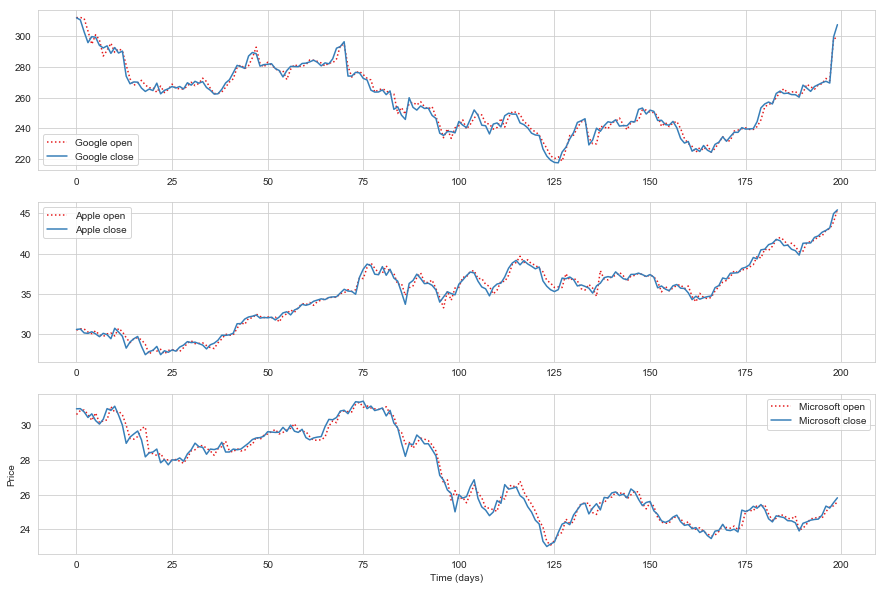

In [16]:
#tickers: goog, aapl, msft
#Truncacted to the first 200 days for clearer visual
plt.figure(figsize=(15, 10));
plt.title('Stock Open Vs. Close')
plt.subplot(3,1,1)
plt.plot(df[df.symbol == 'GOOG'].open.values[:200],linestyle = ':', label='Google open')
plt.plot(df[df.symbol == 'GOOG'].close.values[:200],linestyle = '-', label='Google close')
plt.legend(loc='best')
plt.subplot(3,1,2)
plt.plot(df[df.symbol == 'AAPL'].open.values[:200],linestyle = ':', label='Apple open')
plt.plot(df[df.symbol == 'AAPL'].close.values[:200],linestyle = '-', label='Apple close')
plt.legend(loc='best')
plt.subplot(3,1,3)
plt.plot(df[df.symbol == 'MSFT'].open.values[:200],linestyle = ':', label='Microsoft open')
plt.plot(df[df.symbol == 'MSFT'].close.values[:200],linestyle = '-', label='Microsoft close')
plt.legend(loc='best')


plt.xlabel('Time (days)')
plt.ylabel('Price')

plt.show()

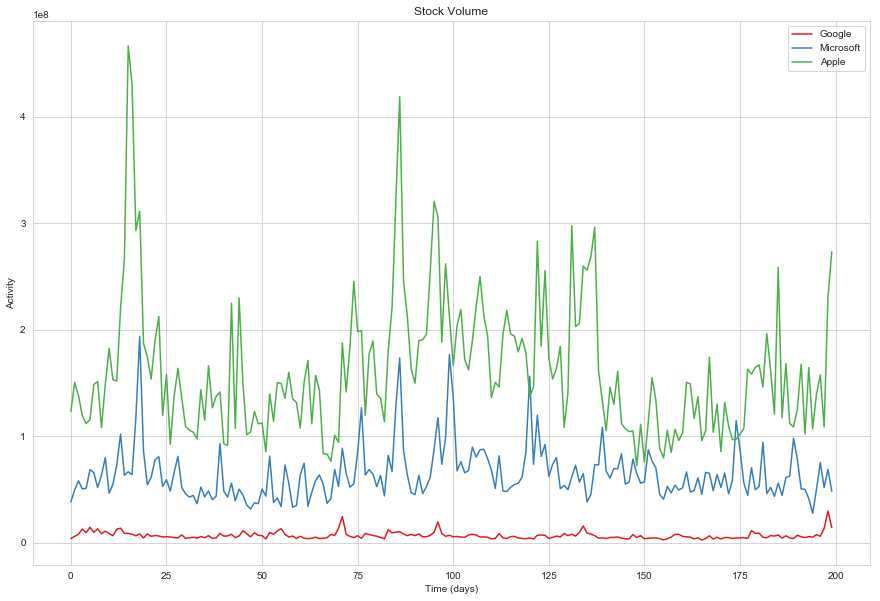

In [17]:
#tickers: goog, aapl, msft
#Truncacted to the first 200 days for clearer visual
plt.figure(figsize=(15, 10));
sns.set_palette("Set1")
plt.plot(df[df.symbol == 'GOOG'].volume.values[:200],linestyle = '-', label='Google')
plt.plot(df[df.symbol == 'MSFT'].volume.values[:200],linestyle = '-', label='Microsoft')
plt.plot(df[df.symbol == 'AAPL'].volume.values[:200],linestyle = '-', label='Apple')
plt.title('Stock Volume')
plt.xlabel('Time (days)')
plt.ylabel('Activity')
plt.legend(loc='best')
plt.show()

That is a ton of trading activity.  Let's review the mean volume for the whole population of stocks in our data.  


In [18]:

def get_vol_mean(sym):
    vols = df[df['symbol'] == sym].volume.values
    return(np.mean(vols))

vol_mean = []
for sym in stocks:
    vol_mean.append(get_vol_mean(sym))


In [19]:
vol_means = pd.DataFrame(vol_mean, columns = ['mean_volume'])
stock_sym = pd.DataFrame(stocks, columns = ['tickers'])
vol_df = pd.concat([stock_sym, vol_means], axis = 1)

In [20]:
vol_df

,tickers,mean_volume
0,JWN,2.392226e+06
1,VTR,2.013865e+06
2,MNK,1.862344e+06
3,VNO,1.154446e+06
4,CMA,2.469429e+06
5,SEE,1.982813e+06
6,UNH,5.889341e+06
7,CRM,7.510623e+06
8,NFLX,2.738426e+07
9,EMN,1.673031e+06


The volumes for some of the stocks are such a large scale it can be hard to conceptualize in a table.  We're not interested in absolutes here, just relative average volumes.  A scatter plot should show that there are a handful of outliers and a relatively tight interval for everything else.

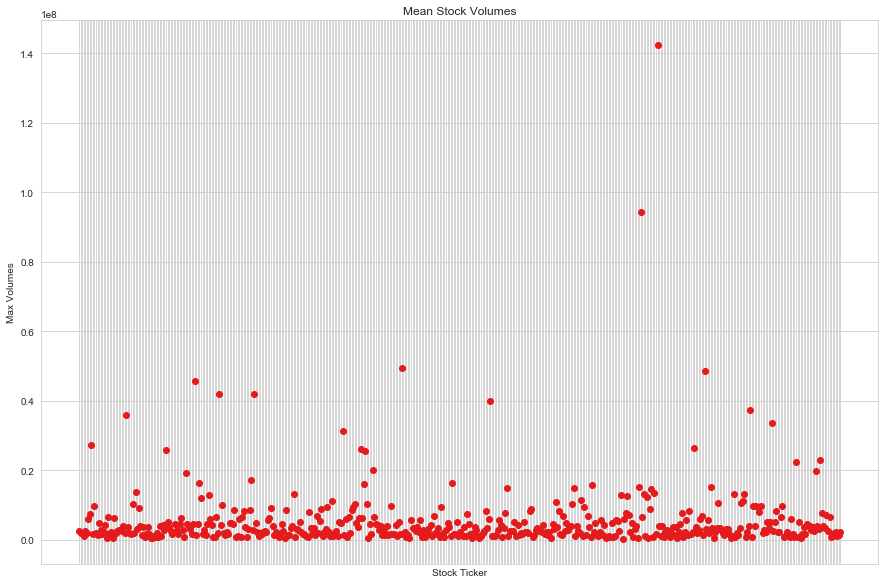

In [21]:
fig, ax = plt.subplots(figsize=(15,10));
sns.set_palette("Set1")
plt.scatter(vol_df['tickers'],vol_df['mean_volume'])
plt.title('Mean Stock Volumes')
plt.ylabel('Max Volumes')
plt.xlabel('Stock Ticker')

ax.tick_params(labelbottom=False)   

plt.show()

Let's look at a histogram of the average volume as well.  

Text(0.5, 0, 'Stock Ticker')

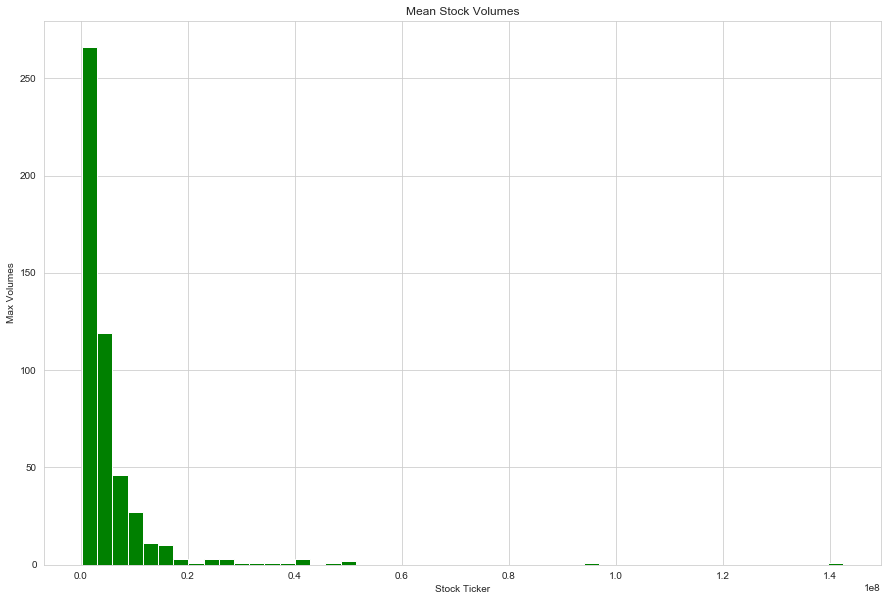

In [22]:
plt.subplots(figsize=(15,10));
sns.set_palette("Set1")
plt.hist(vol_df['mean_volume'],bins=50, color = 'g')
plt.title('Mean Stock Volumes')
plt.ylabel('Max Volumes')
plt.xlabel('Stock Ticker')

Both of these visualizations clearly show that the vast majority of the stocks trade in similar volumes and then outside of that we have those mega-stocks with wild daily trading activity.  The daily volume tells us a few things.  Firstly the size of the company, those outliers are multinational conglomerates who have had very large issuances and likely also a number of stock splits.  Big companies don't often fail quickly; they have also often acheived 'cash cow' status.  These factors make them attractive to the risk-averse investor (like institutional pension funds).  Depending on industry trade winds, like those our 'FAANG' companies (Facebook, Apple, Amazon, Netflix and Google) are facing now, it can also be a signal that these companies may be subject to anti-trust legal action.  Really it's up to the industry analyst to know about these sorts of things before making any recomendations.   

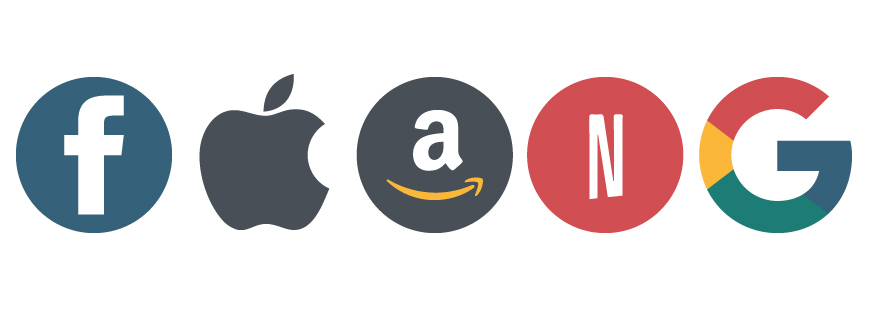

Before we turn to preprocessing the data and our actual modeling, it's worth mentioning that all the exploration that we have done serves multiple purposes.  Firstly, it gives us a good feel for the type of data we are working with and what sort of additional cleaning or preprocessing needs to be done.  Secondly, in this case it gives us an idea for the number of dimensions of the problem we are working with.  Even though we are only working with 5 columns of data, the number of relevant factors to the prediction can very easily spiral out of control.




We can now begin to prep and perform our modelling.  The models we will be using fall under the umbrella of a Recurrent Neural Network.  Due to the dependency between stock prices (day to day and open to close), this should make intuitive sense.  An basic RNN essentially passes one level's output as the input for the following level.  

The first step will be to create a DataFrame consisting of only Google Stock data.  

In [23]:
#creating df and ensuring it contains the data we are expecting
google_df = df[df.symbol =='GOOG']
google_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 6 columns):
symbol    1762 non-null object
open      1762 non-null float64
close     1762 non-null float64
low       1762 non-null float64
high      1762 non-null float64
volume    1762 non-null float64
dtypes: float64(5), object(1)
memory usage: 96.4+ KB


In [24]:
#dropping the symbol column as it contains only google's ticker now and once again checking the df
#google_df.symbol.unique()
google = google_df.drop(columns=['symbol'])

print(google.shape)
google.head()

(1762, 5)


,open,close,low,high,volume
date,,,,,
2010-01-04,312.304948,312.205308,310.955001,313.580158,3927000.0
2010-01-05,312.419511,310.830459,309.610028,312.748278,6031900.0
2010-01-06,311.761979,302.994813,302.048370,311.761979,7987100.0
2010-01-07,303.562685,295.941242,295.218951,303.861575,12876600.0
2010-01-08,294.895159,299.886470,293.455551,300.499172,9483900.0


Why using close price?

In [25]:
#defining a function to scale our dataframe
def normalize_data(df):
    scaler = MinMaxScaler()
    columns = df.columns
    for col in columns:
        df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))
    return df

In [26]:
#scaling (i.e. normalizing) our DataFrame using a MinMax Scalar
goog = normalize_data(google)

So now that we have normalized our data, we can look at a smoother price curve.  Later, we'll drop out the volume column because the scale of volume is the number of trades which is orders of magnitude larger than the prices.  While trading volume can help an investor identify momentum in a stock or validate a trend, this isn't as important in actual price.  It generally only confirms price direction.  We will take care of that in our model so we can drop volume for simplicity. 

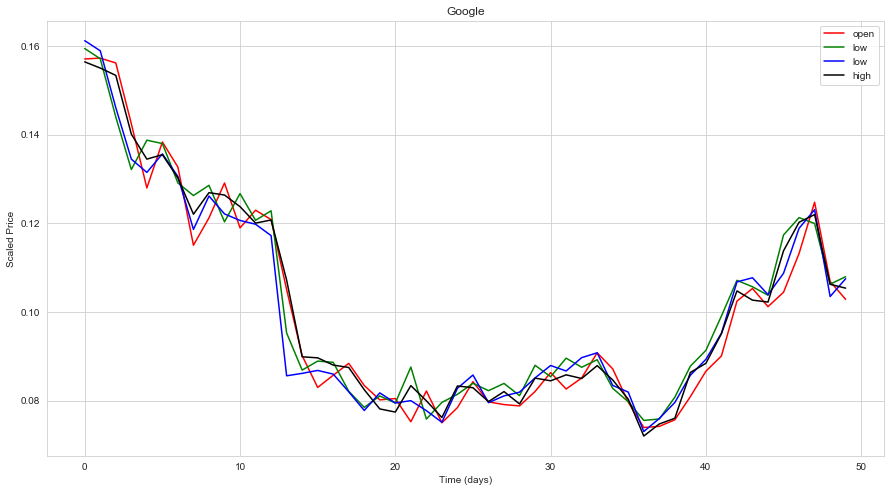

In [27]:
#truncated to the first 50 days for clarity
plt.figure(figsize=(15, 8));
plt.plot(goog.open.values[:50], color='red', label='open')
plt.plot(goog.close.values[:50], color='green', label='low')
plt.plot(goog.low.values[:50], color='blue', label='low')
plt.plot(goog.high.values[:50], color='black', label='high')
plt.title('Google')
plt.xlabel('Time (days)')
plt.ylabel('Scaled Price')
plt.legend(loc='best')
plt.show()

Our Dataset is nearly ready for modelling.  We have to convert the arrays into matricies with dimensions [number of samples, number of time steps, number of features].

In [28]:
goog = goog.drop(columns = ['volume'])

In [29]:
train_size = int(len(goog) * 0.8)
test_size = int(len(goog) - train_size)
train, test = goog[0:train_size], goog[train_size:len(goog)]

In [30]:
print("Train:",train.shape,"\nTest:" ,test.shape)

Train: (1409, 4) 
Test: (353, 4)


In [31]:
# split into input and outputs
train_X ,train_y = train[['open','low','high']],train['close']
test_X, test_y = test[['open','low','high']],test['close']
train_X ,train_y,test_X, test_y = np.array(train_X),np.array(train_y),np.array(test_X),np.array(test_y)
#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1409, 1, 3) (1409,) (353, 1, 3) (353,)


The first model that we use will be a single layer, LSTM, Long Short Term Memory- a simple type of RNN that does not suffer from vanishing/exploding graidents.   The LSTM will serve as a sort of base line for the performance of the other models.  It incorporates teh ability to 'forget' some information that may not be relevant to the task at hand.  It constantly updates the internal model state so it can learn what it should remember, and also what to forget.  

In [32]:
# Building and compiling the Basic LSTM
model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=50, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 1409 samples, validate on 353 samples
Epoch 1/100
 - 0s - loss: 0.0188 - val_loss: 0.0330
Epoch 2/100
 - 0s - loss: 0.0125 - val_loss: 0.0124
Epoch 3/100
 - 0s - loss: 0.0054 - val_loss: 0.0046
Epoch 4/100
 - 0s - loss: 0.0026 - val_loss: 8.0538e-04
Epoch 5/100
 - 0s - loss: 7.5679e-04 - val_loss: 1.0289e-04
Epoch 6/100
 - 0s - loss: 2.4471e-04 - val_loss: 2.6751e-04
Epoch 7/100
 - 0s - loss: 5.9798e-05 - val_loss: 5.2653e-04
Epoch 8/100
 - 0s - loss: 4.4096e-05 - val_loss: 5.4364e-04
Epoch 9/100
 - 0s - loss: 4.3148e-05 - val_loss: 5.5850e-04
Epoch 10/100
 - 0s - loss: 4.4155e-05 - val_loss: 5.5183e-04
Epoch 11/100
 - 0s - loss: 4.5087e-05 - val_loss: 5.4307e-04
Epoch 12/100
 - 0s - loss: 4.5963e-05 - val_loss: 5.3431e-04
Epoch 13/100
 - 0s - loss: 4.6930e-05 - val_loss: 5.2532e-04
Epoch 14/100
 - 0s - loss: 4.8037e-05 - val_loss: 5.1602e-04
Epoch 15/100
 - 0s - loss: 4.9259e-05 - val_loss: 5.0626e-04
Epoch 16/100
 - 0s - loss: 5.0595e-05 - val_loss: 4.9569e-04
Epoch 17/100
 

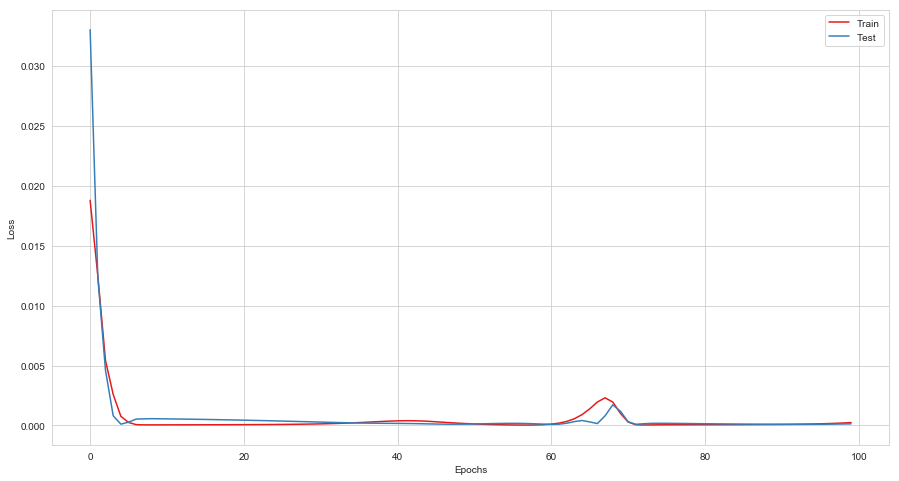

In [33]:
# plotting the history
plt.figure(figsize=(15, 8));
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [34]:
#showing our results
results_train = model.evaluate(train_X, train_y)
results_test = model.evaluate(test_X, test_y)

353/353 [==============================] - 0s 36us/step


In [35]:
print("Training Results: ",results_train)
print("Testing Results: ",results_test)

Training Results:  0.00025504260774586327
Testing Results:  0.00012924770345909247


In [36]:
#making our prediction
pred_train = model.predict(train_X).reshape(-1)
pred_test = model.predict(test_X).reshape(-1)

#Calculating our performance metric in this case MSE
LSTM1_MSE_train = np.mean((pred_train-train_y)**2)
LSTM1_MSE_test = np.mean((pred_test-test_y)**2)

#Showing our results
print(LSTM1_MSE_train)
print(LSTM1_MSE_test)

0.00025504261049364514
0.0001292477259280265


We will store this in a dictionary so we can review all of our models easily once we have finished running them.

In [37]:
model_predict= {}
model_predict['Single Layer LSTM'] = {'Test MSE': LSTM1_MSE_test, 'Train MSE':LSTM1_MSE_train}

Add Layers and 
 discuss tuning and parameters

In [42]:
# Building and compiling the Basic LSTM
model2 = Sequential()
model2.add(LSTM(200, input_shape=(1,3),return_sequences=True))
model2.add(LSTM(200, input_shape=(1,3), dropout=0.1, recurrent_dropout=0.1))
model2.add(Dense(1))
model2.compile(loss='mse', optimizer='adam')

# fit network
history2 = model2.fit(train_X, train_y, epochs=100, batch_size=50, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 1409 samples, validate on 353 samples
Epoch 1/100
 - 2s - loss: 0.0088 - val_loss: 9.9748e-04
Epoch 2/100
 - 0s - loss: 0.0294 - val_loss: 0.0041
Epoch 3/100
 - 0s - loss: 0.0136 - val_loss: 7.5869e-04
Epoch 4/100
 - 0s - loss: 4.8048e-04 - val_loss: 1.5067e-04
Epoch 5/100
 - 0s - loss: 3.0410e-04 - val_loss: 1.2116e-04
Epoch 6/100
 - 0s - loss: 1.3696e-04 - val_loss: 4.0202e-04
Epoch 7/100
 - 0s - loss: 1.6822e-04 - val_loss: 4.8881e-04
Epoch 8/100
 - 0s - loss: 1.8493e-04 - val_loss: 4.4010e-04
Epoch 9/100
 - 0s - loss: 2.0647e-04 - val_loss: 3.7554e-04
Epoch 10/100
 - 0s - loss: 2.1494e-04 - val_loss: 3.5533e-04
Epoch 11/100
 - 0s - loss: 2.3684e-04 - val_loss: 1.5293e-04
Epoch 12/100
 - 0s - loss: 2.8936e-04 - val_loss: 1.1978e-04
Epoch 13/100
 - 0s - loss: 5.5157e-04 - val_loss: 1.1169e-04
Epoch 14/100
 - 0s - loss: 9.2105e-04 - val_loss: 9.6811e-05
Epoch 15/100
 - 0s - loss: 0.0014 - val_loss: 1.3285e-04
Epoch 16/100
 - 0s - loss: 0.0022 - val_loss: 1.9431e-04
Epoch 17/1

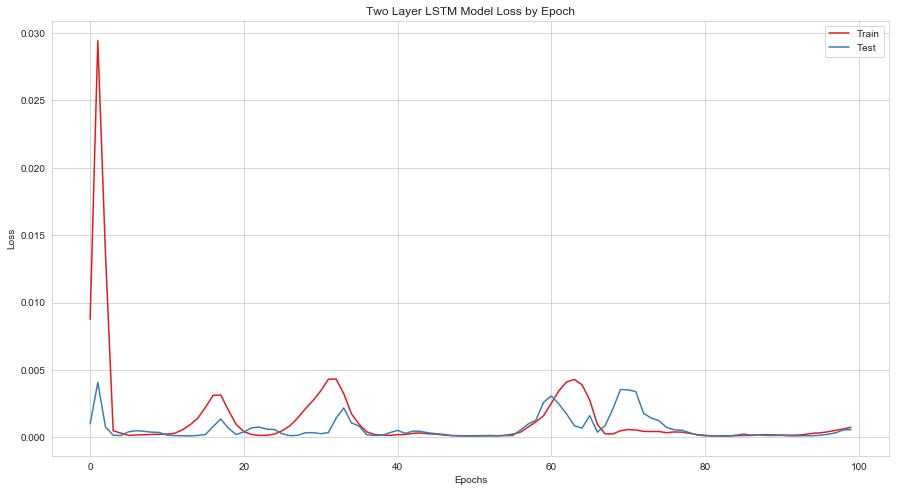

353/353 [==============================] - 0s 57us/step
Training Results:  0.000573460465047895
Testing Results:  0.0005632593403979291
0.0005734604835266484
0.0005632593189855115


In [44]:
# plotting the history
plt.figure(figsize=(15, 8));
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Two Layer LSTM Model Loss by Epoch")
plt.legend()
plt.show()

#showing our results
results_train2 = model2.evaluate(train_X, train_y)
results_test2 = model2.evaluate(test_X, test_y)
print("Training Results: ",results_train2)
print("Testing Results: ",results_test2)

#making our prediction
pred_train2 = model2.predict(train_X).reshape(-1)
pred_test2 = model2.predict(test_X).reshape(-1)

#Calculating our performance metric in this case MSE
LSTM2_MSE_train = np.mean((pred_train2-train_y)**2)
LSTM2_MSE_test = np.mean((pred_test2-test_y)**2)

#Showing our results for our calulations
print(LSTM2_MSE_train)
print(LSTM2_MSE_test)

#adding the next model to the dictionary
model_predict['Multi-Layer LSTM'] = {'Test MSE': LSTM2_MSE_test, 'Train MSE':LSTM2_MSE_train}

Adding another layer improved both the training and testing performance.  This shouldn't be a surprise since the additional neuron has more of a chance to learn about the data.  

We will use a different type of RNN for our next model Gated Recurrent Units, or GRUs. They pass along an internal state at each time step, but only the information that is important to pass on.  It sends forward the Reset Gate and the Update Gate.  The Reset Gate is a function that determines what to be removed from the current state before moving forward.  The Update Gate determines what from previous time step should be used in the current one.  A GRU accomplishes essentially the same 'forgetting and remembering as the LSTM, it just goes about it in a slightly different way.

In [46]:
# Building and compiling a 2 layer GRU model
model3 = Sequential()
model3.add(GRU(200, input_shape=(1,3),return_sequences=True))
model3.add(GRU(200, input_shape=(1,3), dropout=0.1, recurrent_dropout=0.1))
model3.add(Dense(1))
model3.compile(loss='mse', optimizer='adam')

# fit network
history3 = model3.fit(train_X, train_y, epochs=100, batch_size=50, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 1409 samples, validate on 353 samples
Epoch 1/100
 - 2s - loss: 0.0017 - val_loss: 0.0015
Epoch 2/100
 - 0s - loss: 0.0040 - val_loss: 5.5430e-04
Epoch 3/100
 - 0s - loss: 4.2714e-04 - val_loss: 0.0040
Epoch 4/100
 - 0s - loss: 0.0010 - val_loss: 3.6393e-04
Epoch 5/100
 - 0s - loss: 3.2448e-04 - val_loss: 0.0016
Epoch 6/100
 - 0s - loss: 9.7686e-04 - val_loss: 4.6344e-04
Epoch 7/100
 - 0s - loss: 1.7415e-04 - val_loss: 2.8954e-04
Epoch 8/100
 - 0s - loss: 2.4982e-04 - val_loss: 2.5961e-04
Epoch 9/100
 - 0s - loss: 1.4090e-04 - val_loss: 8.6753e-05
Epoch 10/100
 - 0s - loss: 1.3931e-04 - val_loss: 1.2006e-04
Epoch 11/100
 - 0s - loss: 2.7921e-04 - val_loss: 1.1799e-04
Epoch 12/100
 - 0s - loss: 3.4212e-04 - val_loss: 2.1982e-04
Epoch 13/100
 - 0s - loss: 0.0013 - val_loss: 2.7922e-04
Epoch 14/100
 - 0s - loss: 0.0010 - val_loss: 0.0060
Epoch 15/100
 - 0s - loss: 0.0032 - val_loss: 0.0012
Epoch 16/100
 - 0s - loss: 4.8034e-04 - val_loss: 0.0041
Epoch 17/100
 - 0s - loss: 0.0012 

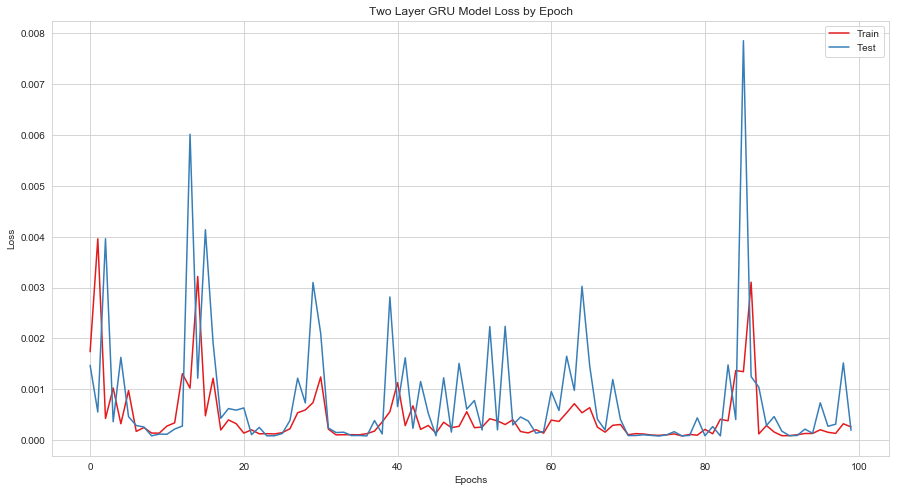

353/353 [==============================] - 0s 64us/step
Training Results:  8.328345457916172e-05
Testing Results:  0.00019580711578955561
8.328345708030729e-05
0.00019580711348272535


In [47]:
# plotting the history
plt.figure(figsize=(15, 8));
plt.plot(history3.history['loss'], label='Train')
plt.plot(history3.history['val_loss'], label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Two Layer GRU Model Loss by Epoch")
plt.legend()
plt.show()

#showing our results
results_train3 = model3.evaluate(train_X, train_y)
results_test3 = model3.evaluate(test_X, test_y)
print("Training Results: ",results_train3)
print("Testing Results: ",results_test3)

#making our prediction
pred_train3 = model3.predict(train_X).reshape(-1)
pred_test3 = model3.predict(test_X).reshape(-1)

#Calculating our performance metric in this case MSE
GRU3_MSE_train = np.mean((pred_train3-train_y)**2)
GRU3_MSE_test = np.mean((pred_test3-test_y)**2)

#Showing our results for our calulations
print(GRU3_MSE_train)
print(GRU3_MSE_test)

#adding the next model to the dictionary
model_predict['Multi-Layer GRU'] = {'Test MSE': GRU3_MSE_test, 'Train MSE':GRU3_MSE_train}

In [51]:
# Building and compiling a 5 layer GRU model
model4 = Sequential()
model4.add(GRU(50, input_shape=(1,3),return_sequences=True))
model4.add(GRU(150, input_shape=(1,3), dropout=0.1, recurrent_dropout=0.1,return_sequences=True))
model4.add(GRU(150, input_shape=(1,3), dropout=0.1, recurrent_dropout=0.1,return_sequences=True))
model4.add(GRU(150, input_shape=(1,3), dropout=0.1, recurrent_dropout=0.1,return_sequences=True))
model4.add(GRU(50, input_shape=(1,3), dropout=0.1, recurrent_dropout=0.1))
model4.add(Dense(1))
model4.compile(loss='mse', optimizer='adam')

# fit network
history4 = model4.fit(train_X, train_y, epochs=100, batch_size=50, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 1409 samples, validate on 353 samples
Epoch 1/100
 - 3s - loss: 0.0037 - val_loss: 0.0345
Epoch 2/100
 - 0s - loss: 0.0464 - val_loss: 0.0225
Epoch 3/100
 - 0s - loss: 0.0267 - val_loss: 0.0187
Epoch 4/100
 - 0s - loss: 0.0071 - val_loss: 1.9244e-04
Epoch 5/100
 - 0s - loss: 0.0021 - val_loss: 0.0032
Epoch 6/100
 - 0s - loss: 0.0032 - val_loss: 0.0020
Epoch 7/100
 - 0s - loss: 0.0027 - val_loss: 0.0034
Epoch 8/100
 - 0s - loss: 0.0049 - val_loss: 0.0018
Epoch 9/100
 - 0s - loss: 0.0039 - val_loss: 0.0030
Epoch 10/100
 - 0s - loss: 0.0019 - val_loss: 0.0041
Epoch 11/100
 - 0s - loss: 9.3520e-04 - val_loss: 0.0072
Epoch 12/100
 - 0s - loss: 0.0010 - val_loss: 0.0053
Epoch 13/100
 - 0s - loss: 8.2504e-04 - val_loss: 0.0054
Epoch 14/100
 - 0s - loss: 0.0013 - val_loss: 0.0039
Epoch 15/100
 - 0s - loss: 8.7706e-04 - val_loss: 0.0033
Epoch 16/100
 - 0s - loss: 0.0014 - val_loss: 0.0031
Epoch 17/100
 - 0s - loss: 9.1994e-04 - val_loss: 0.0050
Epoch 18/100
 - 0s - loss: 6.4655e-04 - v

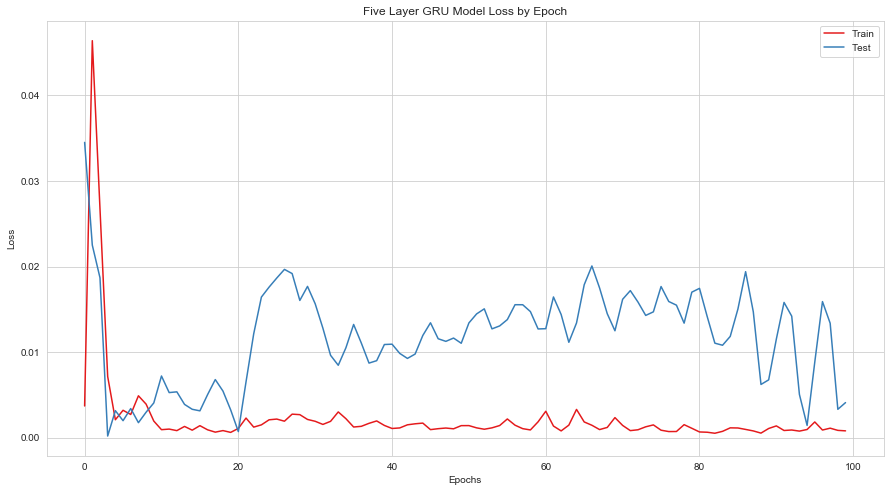

353/353 [==============================] - 0s 82us/step
Training Results:  0.0006431920488601442
Testing Results:  0.004099156682461331
0.0006431920542987596
0.004099156723752257


In [52]:
# plotting the history
plt.figure(figsize=(15, 8));
plt.plot(history4.history['loss'], label='Train')
plt.plot(history4.history['val_loss'], label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Five Layer GRU Model Loss by Epoch")
plt.legend()
plt.show()

#showing our results
results_train4 = model4.evaluate(train_X, train_y)
results_test4 = model4.evaluate(test_X, test_y)
print("Training Results: ",results_train4)
print("Testing Results: ",results_test4)

#making our prediction
pred_train4 = model4.predict(train_X).reshape(-1)
pred_test4 = model4.predict(test_X).reshape(-1)

#Calculating our performance metric in this case MSE
GRU4_MSE_train = np.mean((pred_train4-train_y)**2)
GRU4_MSE_test = np.mean((pred_test4-test_y)**2)

#Showing our results for our calulations
print(GRU4_MSE_train)
print(GRU4_MSE_test)

#adding the next model to the dictionary
model_predict['Five Layer GRU'] = {'Test MSE': GRU4_MSE_test, 'Train MSE':GRU4_MSE_train}

In [58]:
# Building and compiling a 5 layer GRU model where we explicitly change the activation function at each layer
model5 = Sequential()
model5.add(GRU(50, input_shape=(1,3),return_sequences=True,activation='sigmoid'))
model5.add(GRU(150, input_shape=(1,3), dropout=0.1, recurrent_dropout=0.1,return_sequences=True,activation='sigmoid'))
model5.add(GRU(150, input_shape=(1,3), dropout=0.1, recurrent_dropout=0.1,return_sequences=True,activation='sigmoid'))
model5.add(GRU(150, input_shape=(1,3), dropout=0.1, recurrent_dropout=0.1,return_sequences=True,activation='sigmoid'))
model5.add(GRU(50, input_shape=(1,3), dropout=0.1, recurrent_dropout=0.1))
model5.add(Dense(1,activation = 'linear'))
model5.compile(loss='mse', optimizer='adam')

# fit network
history5 = model5.fit(train_X, train_y, epochs=100, batch_size=50, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 1409 samples, validate on 353 samples
Epoch 1/100
 - 4s - loss: 0.0132 - val_loss: 0.1443
Epoch 2/100
 - 0s - loss: 0.0316 - val_loss: 0.0372
Epoch 3/100
 - 0s - loss: 0.1095 - val_loss: 0.0561
Epoch 4/100
 - 0s - loss: 0.1494 - val_loss: 0.3401
Epoch 5/100
 - 0s - loss: 0.0531 - val_loss: 0.2538
Epoch 6/100
 - 0s - loss: 0.0662 - val_loss: 0.2789
Epoch 7/100
 - 0s - loss: 0.0599 - val_loss: 0.2750
Epoch 8/100
 - 0s - loss: 0.0604 - val_loss: 0.2786
Epoch 9/100
 - 0s - loss: 0.0589 - val_loss: 0.2803
Epoch 10/100
 - 0s - loss: 0.0585 - val_loss: 0.2832
Epoch 11/100
 - 0s - loss: 0.0571 - val_loss: 0.2845
Epoch 12/100
 - 0s - loss: 0.0564 - val_loss: 0.2862
Epoch 13/100
 - 0s - loss: 0.0551 - val_loss: 0.2863
Epoch 14/100
 - 0s - loss: 0.0554 - val_loss: 0.2894
Epoch 15/100
 - 0s - loss: 0.0545 - val_loss: 0.2898
Epoch 16/100
 - 0s - loss: 0.0545 - val_loss: 0.2912
Epoch 17/100
 - 0s - loss: 0.0534 - val_loss: 0.2914
Epoch 18/100
 - 0s - loss: 0.0535 - val_loss: 0.2927
Epoch 19

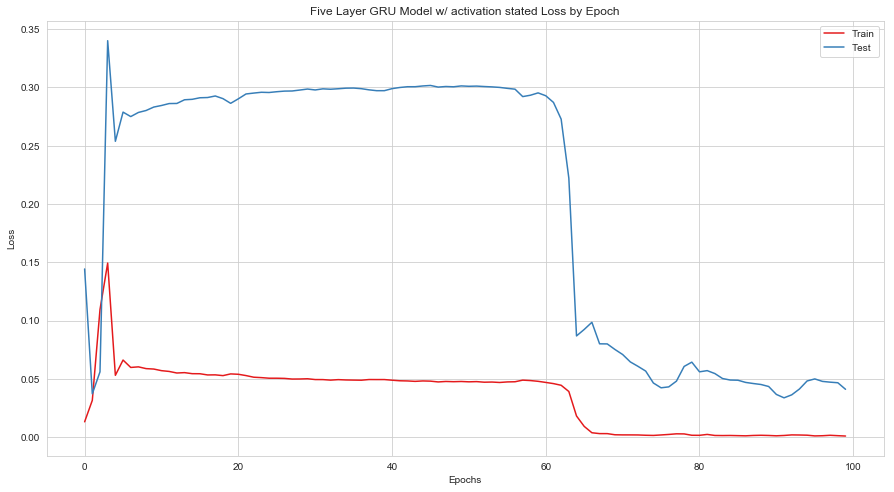

353/353 [==============================] - 0s 106us/step
Training Results:  0.0002454772074042566
Testing Results:  0.04111785287559877
0.00024547721117927434
0.041117853584520074


In [59]:
# plotting the history
plt.figure(figsize=(15, 8));
plt.plot(history5.history['loss'], label='Train')
plt.plot(history5.history['val_loss'], label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Five Layer GRU Model w/ activation stated Loss by Epoch")
plt.legend()
plt.show()

#showing our results
results_train5 = model5.evaluate(train_X, train_y)
results_test5 = model5.evaluate(test_X, test_y)
print("Training Results: ",results_train5)
print("Testing Results: ",results_test5)

#making our prediction
pred_train5 = model5.predict(train_X).reshape(-1)
pred_test5 = model5.predict(test_X).reshape(-1)

#Calculating our performance metric in this case MSE
GRU5_MSE_train = np.mean((pred_train5-train_y)**2)
GRU5_MSE_test = np.mean((pred_test5-test_y)**2)

#Showing our results for our calulations 
print(GRU5_MSE_train)
print(GRU5_MSE_test)

#adding the next model to the dictionary
model_predict["Five Layer GRU w/ stated activation"] = {'Test MSE': GRU5_MSE_test, 'Train MSE':GRU5_MSE_train}

Now that we have 5 models and their accuracy metrics, let's see them all in one place so we can make a decision about which model is best.  While the general academic community cannot pwhether GRUs or LSTMs are superior to one another. In practice, GRUs tend to have a slight advantage in many use cases, but this is far from guaranteed. 

In [56]:
for key in model_predict.keys():
    print(str(key),model_predict[key])

Single Layer LSTM {'Test MSE': 0.0001292477259280265, 'Train MSE': 0.00025504261049364514}
Multi-Layer LSTM {'Test MSE': 0.0005632593189855115, 'Train MSE': 0.0005734604835266484}
Multi-Layer GRU {'Test MSE': 0.00019580711348272535, 'Train MSE': 8.328345708030729e-05}
Five Layer GRU {'Test MSE': 0.004099156723752257, 'Train MSE': 0.0006431920542987596}
Five Layer GRU w/ stated activation {'Test MSE': 0.0453564358855309, 'Train MSE': 0.0006715478524549032}


caveat about test accuracy and over /underfitting

business recomendations and next steps

summary of steps